<a href="https://colab.research.google.com/github/cindysotton/Video-Game-Prediction/blob/main/Regression_JV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
import warnings
warnings.filterwarnings('ignore')

# import du dataset
df = pd.read_csv('/content/drive/MyDrive/Formation Data Analyst/Fichiers Projet Data/vgsales_all.csv')

# supression des colonnes inutiles
df = df.drop(["Rank"], axis=1)

# Processing des NaN
df = df.dropna(subset=['Year'])
df['Year'] = df['Year'].astype(int)
df  = (df[(df['Year'] < 2022) ])
df = df.dropna(subset=['Global_Sales'])
df = df.dropna(subset=['Critic_Score']) #pas dans le script de Dorian 
# analyse des NaN restants
df.isna().sum(axis=0)
# remplacer les NaN par O pour éviter la création d'array lors du pivot
df['NA_Sales'] = df['NA_Sales'].fillna(0)
df['PAL_Sales'] = df['PAL_Sales'].fillna(0)
df['JP_Sales'] = df['JP_Sales'].fillna(0)
df['Other_Sales'] = df['Other_Sales'].fillna(0)

# renommer pour plus de compréhension
df = df.rename(columns={'Developer' : 'Studio'})
df = df.rename(columns={'PAL_Sales' : 'EU_Sales'})
#reformatage pour effacer les espaces
df['Publisher'] = df['Publisher'].str.strip()
df['Studio'] = df['Studio'].str.strip()

#supression des doublons
df = df.drop_duplicates(keep = 'first')

Mounted at /content/drive


In [ ]:
# après une analyse de la répartition des valeurs, on enlève les variables extreme (minoritaire)
df = df.drop(df[(df['Year'] == '1989')| 
                (df['Year'] == '1987')| 
                (df['Year'] == '1985')| 
                (df['Year'] == '2020')|
                (df['Year'] == '2019')|
                (df['Year'] == '1990')|
                (df['Year'] == '1992')|
                (df['Year'] == '1994')|
                (df['Year'] == '1991')|
                (df['Year'] == '1993')].index)

df = df.drop(df[(df['Genre'] == 'Visual Novel')|
                (df['Genre'] == 'Board Game')| 
                (df['Genre'] == 'Sandbox')|
                (df['Genre'] == 'MMO')| 
                (df['Genre'] == 'Education')].index)

df = df.drop(df[(df['Platform'] == 'GEN')|
                (df['Platform'] == 'VC')|
                (df['Platform'] == 'XBL')|
                (df['Platform'] == 'PSN')|
                (df['Platform'] == 'NES')|
                (df['Platform'] == 'GBC')|
                (df['Platform'] == 'PSV')|
                (df['Platform'] == 'SAT')|
                (df['Platform'] == 'GB')|
                (df['Platform'] == 'SNES')].index)

In [ ]:
# Split de la colonne Platform par plateforme afin de pouvoir réaliser un pivot par la suite qui nous permettra d'avoir une ligne par jeu
df = pd.get_dummies(data=df, columns=['Platform'])
df = df.fillna(0)

In [ ]:
# Modification du DataFrame pour avoir une ligne par jeu
df =df.pivot_table(index='Name',aggfunc={'Year' : lambda x: x.mode().iat[0],
                                         'Genre': lambda x: x.mode().iat[0],
                                         'Studio': lambda x: x.mode().iat[0],
                                         'Publisher' : lambda x: x.mode().iat[0],
                                         'NA_Sales':'sum',
                                         'EU_Sales':'sum',
                                         'JP_Sales':'sum',
                                         'Other_Sales':'sum',
                                         'Global_Sales':'sum',
                                         'Critic_Score':lambda x: x.mode().iat[0],
                                            'Platform_3DS':'sum',
                                            'Platform_DC':'sum',
                                            'Platform_DS':'sum',
                                            'Platform_GBA':'sum',
                                            'Platform_GC':'sum',
                                            'Platform_N64':'sum',
                                         'Platform_NS':'sum',
                                            'Platform_PC':'sum',
                                            'Platform_PS':'sum',
                                            'Platform_PS2':'sum',
                                            'Platform_PS3':'sum',
                                            'Platform_PS4':'sum',
                                            'Platform_PSP':'sum',
                                            'Platform_Wii':'sum',
                                            'Platform_WiiU':'sum',
                                            'Platform_X360':'sum',
                                            'Platform_XB':'sum',
                                            'Platform_XOne':'sum',
                                           })


# Mise en forme de colonnes pour les avoir dans un ordre plus pertinent
df = df.reindex(columns=['Name', 'Year', 'Genre', 'Publisher', 'Studio', 'Critic_Score','NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales',
       'Global_Sales', 'Platform_3DS',
       'Platform_DC', 'Platform_DS', 'Platform_GBA', 'Platform_GC',
       'Platform_N64', 'Platform_NS', 'Platform_PC', 'Platform_PS',
       'Platform_PS2', 'Platform_PS3', 'Platform_PS4', 'Platform_PSP',
       'Platform_Wii', 'Platform_WiiU', 'Platform_X360', 'Platform_XB',
       'Platform_XOne'])

In [ ]:
# supression de Name car doublon et vide
df = df.drop(["Name"], axis=1)

In [ ]:
# Reconstituer la colonne Platform
# Remplacer les 2 par des 1 pour avoir l'équivalent de oui/non
df['Platform_3DS'] = df['Platform_3DS'].replace(['2'],[1])
df['Platform_DS'] = df['Platform_DS'].replace(['2'],[1])
df['Platform_PS2'] = df['Platform_PS2'].replace(['2'],[1])

# Fusionner les deux colonnes en une seule colonne
df['TotalPlatform'] = df[['Platform_3DS', 'Platform_DC', 'Platform_DS', 'Platform_GBA', 'Platform_GC', 'Platform_N64', 'Platform_NS', 'Platform_PC', 'Platform_PS', 'Platform_PS2', 'Platform_PS3', 'Platform_PS4', 'Platform_PSP', 'Platform_Wii', 'Platform_WiiU', 'Platform_X360', 'Platform_XB', 'Platform_XOne']].sum(axis=1)

# Extraire les colonnes générées par le get_dummies
platform_columns = [col for col in df.columns if col.startswith("Platform_")]

# Appliquer les conditions à toutes les lignes du DataFrame
df.loc[df['TotalPlatform'] > 2, 'Platform'] = 'Multi_Plateforme'
df.loc[df['TotalPlatform'] <= 2, 'Platform'] = df[platform_columns].idxmax(axis=1).str.replace("Platform_", "")

# Supprimer les colonnes générées par get_dummies
df.drop(platform_columns, axis=1, inplace=True)
df = df.drop(['TotalPlatform'],axis=1)

# Réinitialiser l'index
df.reset_index(inplace=True)

In [ ]:
# Afin de limiter le nb de colonne lors de l'encodage nous avons clusterisé les variables avec bcp de modalités
# Clusterisation Studio
df_studio = df.groupby(['Studio']).agg({'Global_Sales':'sum'})
df_studio['cat_studio'] = pd.qcut(df_studio['Global_Sales'], 
               4,
                labels=['0','1','2','3'])

# Clusterisation Publisher
df_publi = df.groupby(['Publisher']).agg({'Global_Sales':'sum'})
df_publi['cat_publi'] = pd.qcut(df_publi['Global_Sales'], 
               4,
                labels=['0','1','2','3'])

df = df.merge(right = df_publi, on = 'Publisher', how = 'left') 
df = df.merge(right = df_studio, on = 'Studio', how = 'left')

df = df.drop(["Global_Sales_y"], axis=1)
df = df.drop(["Global_Sales"], axis=1)
df = df.drop(["Studio"], axis=1)
df = df.drop(["Publisher"], axis=1)
df = df.rename(columns={'Global_Sales_x' : 'Global_Sales'})

In [ ]:
# ici nous supprimons les colonnes inutiles à la modélisation
df = df.drop(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)

In [ ]:
from sklearn import model_selection
from sklearn import ensemble
from sklearn import svm
from sklearn import neighbors
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder

data = df.drop('Global_Sales',axis=1)
# isoler la variable cible
y = df['Global_Sales']
# Création du jeu d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(data,y,test_size=0.3,random_state=42)

# Séparation des variables catégorielles et numértique
num_train = X_train[['Critic_Score','Year','cat_publi','cat_studio']]
num_test = X_test[['Critic_Score','Year','cat_publi','cat_studio']]

cat_train = X_train.drop(['Critic_Score','Year','cat_publi','cat_studio','Name'], axis=1)
cat_test = X_test.drop(['Critic_Score','Year','cat_publi','cat_studio','Name'], axis=1)

print("Train Set:", X_train.shape)
print("Test Set:", X_test.shape)

Train Set: (2380, 7)
Test Set: (1020, 7)


In [ ]:
# Nous n'avons pas de NaN donc on ne réalise pas de Simple Imputer
df.isna().sum()

Name            0
Year            0
Genre           0
Critic_Score    0
Global_Sales    0
Platform        0
cat_publi       0
cat_studio      0
dtype: int64

In [ ]:
#Encoder les variables catégorielles
oneh = OneHotEncoder(drop="first", sparse=False)

cat_train = pd.DataFrame(oneh.fit_transform(cat_train), columns = oneh.get_feature_names_out())
cat_test = pd.DataFrame(oneh.fit_transform(cat_test), columns = oneh.get_feature_names_out())

X_train_new = pd.concat([num_train.reset_index() ,cat_train.reset_index()], axis = 1)
X_test_new = pd.concat([num_test.reset_index() ,cat_test.reset_index()], axis = 1)
X_test_new.head()

print(X_test_new.shape)
print(X_train_new.shape)

(1020, 38)
(2380, 38)


In [ ]:
# on vérifie les tailles
X_test_new = X_test_new.drop(columns='index')
X_train_new = X_train_new.drop(columns='index')
X_train_new.shape,X_test_new.shape

((2380, 36), (1020, 36))

In [ ]:
# vu qu'il s'agit d'une variable en quantité nous avons choisi un modèle de regression
# import des modeles
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor

# normalisation des données
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

In [ ]:
# 1/ La régression Logistique
from sklearn.linear_model import LinearRegression

cl1 = LinearRegression()
cl1.fit(X_train_scaled, y_train)
print("Accuracy score de la Régression Logistique sur le jeux d'entrainement : ",
     cl1.score(X_train_scaled, y_train))

# 2/ Le modèle Decision Tree
cl2 = DecisionTreeRegressor()
cl2.fit(X_train_scaled, y_train)
print("Accuracy score de l'Arbre de Décision sur le jeux d'entrainement  : ",
     cl2.score(X_train_scaled, y_train))

# 3/ Random Forest
from sklearn.ensemble import RandomForestRegressor
cl3 = RandomForestRegressor()
cl3.fit(X_train_scaled, y_train)
print("Accuracy score du Random Forest sur le jeux d'entrainement : ",
     cl3.score(X_train_scaled, y_train))

#analyse des scores de performances des modèles
print("Accuracy score de la Régression Logistique sur le jeux de test : ",
     cl1.score(X_test_scaled, y_test))
print("Accuracy score de l'Arbre de Décision sur le jeux de test: ",
     cl2.score(X_test_scaled, y_test))
print("Accuracy score du Random Forest sur le jeux de test : ",
     cl3.score(X_test_scaled, y_test))

Accuracy score de la Régression Logistique sur le jeux d'entrainement :  0.21122154841830665
Accuracy score de l'Arbre de Décision sur le jeux d'entrainement  :  0.973932818111767
Accuracy score du Random Forest sur le jeux d'entrainement :  0.8605217623092671
Accuracy score de la Régression Logistique sur le jeux de test :  0.11884109217929484
Accuracy score de l'Arbre de Décision sur le jeux de test:  -0.14593461080075487
Accuracy score du Random Forest sur le jeux de test :  0.10762196448540151


<Axes: >

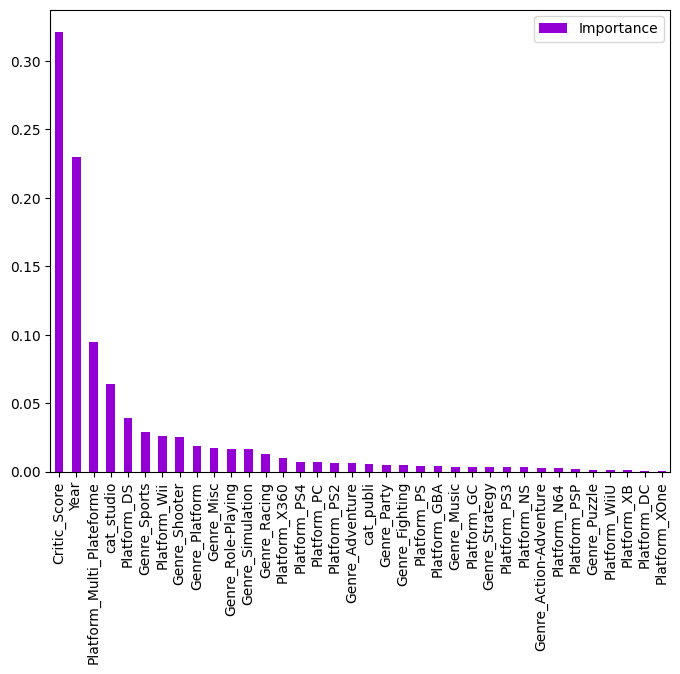

In [ ]:
# analyse de l'importance de chaque variable afin d'affiner notre modèle
cl3.feature_importances_

import matplotlib.pyplot as plt
%matplotlib inline
feat_importances = pd.DataFrame(cl3.feature_importances_, 
                                index=X_test_new.columns, 
                                columns=["Importance"])

feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6),color="darkviolet")

In [ ]:
# nous faisons la même opération avec les varaibles les plus importantes
data = df[['Critic_Score','Year']]
y = df['Global_Sales']
X_train, X_test, y_train, y_test = train_test_split(data,y,test_size=0.3,random_state=42)

print("Train Set:", X_train.shape)
print("Test Set:", X_test.shape)

Train Set: (2380, 2)
Test Set: (1020, 2)


In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new)
X_test_scaled = scaler.transform(X_test_new)

In [ ]:
# 1/ La régression Logistique
cl1 = LinearRegression()
cl1.fit(X_train_scaled, y_train)
print("Accuracy score de la Régression Logistique sur le jeux d'entrainement : ",
     cl1.score(X_train_scaled, y_train))

# 2/ Le modèle Decision Tree
cl2 = DecisionTreeRegressor()
cl2.fit(X_train_scaled, y_train)
print("Accuracy score de l'Arbre de Décision sur le jeux d'entrainement  : ",
     cl2.score(X_train_scaled, y_train))

# 3/ Random Forest
cl3 = RandomForestRegressor()
cl3.fit(X_train_scaled, y_train)
print("Accuracy score du Random Forest sur le jeux d'entrainement : ",
     cl3.score(X_train_scaled, y_train))

print("Accuracy score de la Régression Logistique sur le jeux de test : ",
     cl1.score(X_test_scaled, y_test))
print("Accuracy score de l'Arbre de Décision sur le jeux de test: ",
     cl2.score(X_test_scaled, y_test))
print("Accuracy score du Random Forest sur le jeux de test : ",
     cl3.score(X_test_scaled, y_test))

Accuracy score de la Régression Logistique sur le jeux d'entrainement :  0.21122154841830665
Accuracy score de l'Arbre de Décision sur le jeux d'entrainement  :  0.973932818111767
Accuracy score du Random Forest sur le jeux d'entrainement :  0.8574755553276462
Accuracy score de la Régression Logistique sur le jeux de test :  0.11884109217929484
Accuracy score de l'Arbre de Décision sur le jeux de test:  -0.18603429696408336
Accuracy score du Random Forest sur le jeux de test :  0.12353571399063534


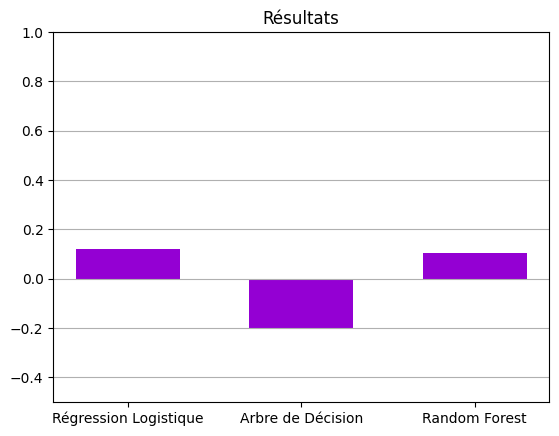

In [ ]:
#analyse des résultats
x = ["Régression Logistique","Arbre de Décision","Random Forest"]
y = [0.11884109217929484,-0.2,0.10571851988597436]

plt.bar(x, y , color = 'darkviolet', width = 0.6) 
plt.ylim(-0.5,1)
plt.grid(axis='y')
plt.title("Résultats");

In [ ]:
# nous souhaitions analyser les meilleurs hyper paramètres
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'criterion': ['squared_error', 'friedman_mse','poisson'], 'max_depth': np.arange(3, 20)}
clf_gs = GridSearchCV(cl3, param_grid, cv=10, verbose=1)
clf_gs.fit(X_train_scaled, y_train)
print(clf_gs.best_params_)
print(clf_gs.score(X_test_scaled, y_test))

Fitting 10 folds for each of 51 candidates, totalling 510 fits
{'criterion': 'poisson', 'max_depth': 3}
0.13033158628180141
